# Computer Vision Playground: Needle
## Author: Dimitri Lezcano
This is an image processing playground Python Notebook in order to test image processing solutions.

## Imports

In [1]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.optimize import Bounds, minimize
from scipy.interpolate import BPoly

# pltting tools
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting @UnusedImport

# NURBS
from geomdl import fitting
from geomdl.visualization import VisMPL

# custom code
from stereo_needle_proc import *
from image_processing import find_param_along_bspline
from BSpline1D import BSpline1D
from BSpline3D import BSpline3D

## Load Image Files

In [2]:
# directory settings
stereo_dir = "../data/"
needle_dir = stereo_dir + "needle_examples/"  # needle insertion examples directory
grid_dir = stereo_dir + "grid_only/"  # grid testing directory
valid_dir = stereo_dir + "stereo_validation_jig/"  # validation directory

curvature_dir = glob.glob( valid_dir + 'k_*/' )  # validation curvature directories

# load matlab stereo calibration parameters
stereo_param_dir = "../calibration/Stereo_Camera_Calibration_10-23-2020"
stereo_param_file = stereo_param_dir + "/calibrationSession_params-error_opencv-struct.mat"
stereo_params = load_stereoparams_matlab( stereo_param_file )

(768, 1024, 3) (768, 1024, 3)


c:\users\dlezcan1\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\arraypad.py:490: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array(x)


Text(0.5, 1.0, 'Raw image')

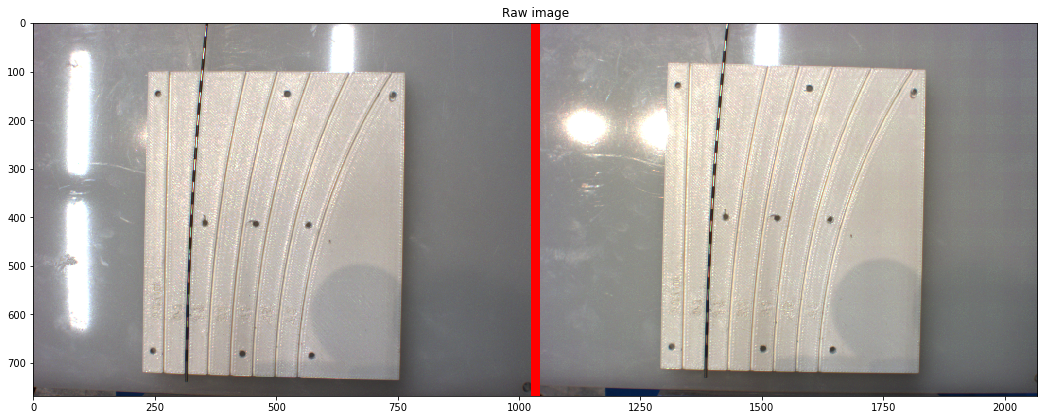

In [3]:
# image files
img_num = 0
left_file = curvature_dir[0] + f"left-{img_num:04d}.png"
right_file = curvature_dir[0] + f"right-{img_num:04d}.png"

# load the images
left_img = cv.imread(left_file, cv.IMREAD_ANYCOLOR)
left_img = cv.cvtColor(left_img, cv.COLOR_BGR2RGB)
right_img = cv.imread(right_file, cv.IMREAD_ANYCOLOR)
right_img = cv.cvtColor(right_img, cv.COLOR_BGR2RGB)

# show the images
print(left_img.shape, right_img.shape)
plt.figure(figsize=(18,12))
plt.imshow(imconcat(left_img, right_img, [255,0, 0]))
plt.title('Raw image')

## Image Processing
Image processing functions to test.

In [5]:
def roi_image2(reg_of_int, image_size):
    
    roi_bool = np.zeros(image_size[:2], dtype=bool) # initialization
    
    tl, br = reg_of_int # unpack

    # check for negative indices
    for i, (tl_i, br_i) in enumerate(zip(tl, br)):
        if tl_i < 0:
            tl[i] = image_size[i] + tl_i + 1
            
        if br_i < 0:
            br[i] = image_size[i] + br_i + 1
            
    # for
    
    roi_bool[tl[0]:br[0], tl[1]:br[1]] = True
    
    return roi_bool
    
# roi_image2


# USE THIS ONE!
def roi_image3(reg_of_int, image_size):
    roi_bool = np.ones(image_size[:2], dtype=bool)
    
    roi_bool = roi(roi_bool, reg_of_int).astype(bool)
    
    return roi_bool
    
# roi_image3

# USE THIS ONE!
def blackout_image3(bo_regions: list, image_size):
    bo_bool = np.ones(image_size[:2], dtype=bool)
    
    bo_bool = blackout_regions(bo_bool, bo_regions)
    
    return bo_bool

# blackout_image3
    
    
a, b = [[0,0], [1,2]]
region = [a, b]
img_shape = (3,5,10)

roi_img = roi_image([a,b], img_shape)
method2 = roi_image2([a,b], img_shape)
method3 = roi_image3([a,b], img_shape)

bo_img = blackout_image([region], img_shape)
bo3 =  blackout_image3([region], img_shape)

print('roi\n', roi_img)
print('roi2:\n', method2)
print('roi3:\n', method3)

print('equals?:', np.all(method2 == method3))
print()

print('bor\n', bo_img)
print('bor3:\n',bo3)

print('not equal?', np.all(bo3 != method3), '\n', bo3 != method3)


roi
 [[ True  True False False False]
 [False False False False False]
 [False False False False False]]
roi2:
 [[ True  True False False False]
 [False False False False False]
 [False False False False False]]
roi3:
 [[ True  True False False False]
 [False False False False False]
 [False False False False False]]
equals?: True

bor
 [[False False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
bor3:
 [[False False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]
not equal? True 
 [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


In [4]:
def imgproc_jig2( left_img, right_img,
                         bor_l:list = [], bor_r:list = [],
                         roi_l:tuple = (), roi_r:tuple = (),
                         proc_show: bool = False ):
    ''' wrapper function to process the left and right image pair for needle
        centerline identification
        
     '''
    
    # convert to grayscale if not already
    if left_img.ndim > 2:
        left_img = cv.cvtColor( left_img, cv.COLOR_BGR2GRAY )

    # if
    if right_img.ndim > 2:
        right_img = cv.cvtColor( right_img, cv.COLOR_BGR2GRAY )

    # if
    
#     # image processing 1
#     left_canny, right_canny = canny(left_img, right_img, lo_thresh=150, hi_thresh=200)
#     left_roi1 = roi( left_canny, roi_l, full = True )
#     right_roi1 = roi( right_canny, roi_r, full = True )
    
#     left_thresh_bo1 = blackout_regions( left_roi1, bor_l )
#     right_thresh_bo1 = blackout_regions( right_roi1, bor_r )
    
#     left_close1, right_close1 = bin_close( left_thresh_bo1, right_thresh_bo1, ksize = ( 7, 7 ) )
    
    # start the image qprocessing
    left_thresh, right_thresh = thresh( left_img, right_img, thresh=30 )
    
    left_roi = roi( left_thresh, roi_l, full = True )
    right_roi = roi( right_thresh, roi_r, full = True )
    
    left_thresh_bo = blackout_regions( left_roi, bor_l )
    right_thresh_bo = blackout_regions( right_roi, bor_r )
        
    left_tmed, right_tmed = median_blur( left_thresh_bo, right_thresh_bo, ksize = 7 )
    
    left_close, right_close = bin_close( left_tmed, right_tmed, ksize = ( 7, 7 ) )
    
    left_open, right_open = bin_open( left_close, right_close, ksize = ( 3, 3 ) )
    
    left_dil, right_dil = bin_dilate( left_close, right_close, ksize = ( 3, 3 ) )
    
    left_skel, right_skel = skeleton( left_dil, right_dil )
    
    # get the contours ( sorted by length)
    conts_l, conts_r = contours( left_skel, right_skel )
    
    # fit a bspline to the contours
    conts_l_filt = [c for c in conts_l if len(c) > 0]
    conts_r_filt = [c for c in conts_r if len(c) > 0]
    pts_l = np.unique(np.vstack(conts_l_filt).squeeze(), axis=0)
    pts_r = np.unique(np.vstack(conts_r_filt).squeeze(), axis=0)
    bspline_l = BSpline1D(pts_l[:,0], pts_l[:,1], k=3)
    bspline_r = BSpline1D(pts_r[:,0], pts_r[:,1], k=3)
        
    # grab all of the bspline points
    s = np.linspace(0, 1, 200)
    bspline_pts_l = np.vstack((bspline_l.unscale(s), bspline_l(bspline_l.unscale(s)))).T
    bspline_pts_r = np.vstack((bspline_r.unscale(s), bspline_r(bspline_r.unscale(s)))).T
    
    if proc_show:
        plt.ion()
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_thresh, right_thresh, 150 ), cmap = 'gray' )
        plt.title( 'adaptive thresholding' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_roi, right_roi, 150 ), cmap = 'gray' )
        plt.title( 'roi: after thresholding' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_thresh_bo, right_thresh_bo, 150 ), cmap = 'gray' )
        plt.title( 'region suppression: roi' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_tmed, right_tmed, 150 ), cmap = 'gray' )
        plt.title( 'median filtering: after region suppression' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_close, right_close, 150 ), cmap = 'gray' )
        plt.title( 'closing: after median' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_open, right_open, 150 ), cmap = 'gray' )
        plt.title( 'opening: after closing' )

        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_open, right_open, 150 ), cmap = 'gray' )
        plt.title( 'dilation: after closing' )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( left_skel, right_skel, 150 ), cmap = 'gray' )
        plt.title( 'skeletization: after dilation' )
        
        cont_left = left_img.copy().astype( np.uint8 )
        cont_right = right_img.copy().astype( np.uint8 )
        
        cont_left = cv.cvtColor( cont_left, cv.COLOR_GRAY2RGB )
        cont_right = cv.cvtColor( cont_right, cv.COLOR_GRAY2RGB )
        
        cv.drawContours( cont_left, conts_l_filt, -1, ( 255, 0, 0 ), 6 )
        cv.drawContours( cont_right, conts_r_filt, -1, ( 255, 0, 0 ), 6 )
        
        cv.drawContours( cont_left, conts_l_filt, 0, ( 0, 255, 0 ), 3 )
        cv.drawContours( cont_right, conts_r_filt, 0, ( 0, 255, 0 ), 3 )
        
        plt.figure(figsize=(18,12))
        plt.imshow( imconcat( cont_left, cont_right, 150 ), cmap = 'gray' )
        plt.title( 'contours' )
        
        impad = 20
        bspl_left_img = cv.cvtColor(left_img.copy().astype(np.uint8), cv.COLOR_GRAY2RGB)
        bspl_right_img = cv.cvtColor(right_img.copy().astype(np.uint8), cv.COLOR_GRAY2RGB)
        
        plt.figure(figsize=(18,12))
        plt.imshow(imconcat(bspl_left_img, bspl_right_img, [0, 0, 255],pad_size=impad))
        plt.plot(bspline_pts_l[:,0], bspline_pts_l[:,1], 'r-')
        plt.plot(bspline_pts_r[:,0]  + left_img.shape[1] + impad, bspline_pts_r[:,1], 'r-')
        plt.title('bspline fits')
        
        
    # if
    
    return left_skel, right_skel, [np.expand_dims(bspline_pts_l, axis=1)], [np.expand_dims(bspline_pts_r, axis=1)], conts_l_filt, conts_r_filt
    
# imgproc_jig2


In [5]:
def match_bsplines(img_l, img_r, bspline_l, bspline_r, win_size, threshold=40):
    img_lg = cv.cvtColor(img_l, cv.COLOR_BGR2GRAY)
    img_rg = cv.cvtColor(img_r, cv.COLOR_BGR2GRAY)

    img_lt, img_rt = thresh(img_lg, img_rg, thresh=threshold)
    
    img_lgn = (img_lg - np.mean(img_lg))/np.std(img_lg)
    img_rgn = (img_rg - np.mean(img_rg))/np.std(img_rg)
    
    s = np.linspace(0, 1, 200)
    
    if win_size % 2 != 1:
        raise ValueError('win_size must be odd.')
        
    # if
    
    # window points
    dp = np.arange(win_size) - win_size//2
    dx, dy = np.meshgrid(dp, dp) # window poitns
    dpts = np.hstack( (dx.reshape(-1,1), dy.reshape(-1,1)) ).reshape(1, -1, 2)
    
    def cost_fn(s2_0, img1, img2, bspline1, bspline2):
        nonlocal dpts
        s1 = np.linspace(0, 1, 200)
        s2 = np.linspace(s2_0, 1, 200)
            
        # grab the image pixel values
        x1 = bspline1.unscale(s1)
        pts1 = np.vstack((x1, bspline1(x1))).T.reshape(-1,1,2).astype(int)
        win_pts1 = pts1 + dpts
        img1_v = img1[win_pts1[:,:,0], win_pts1[:,:,1]]
        
        x2 = bspline2.unscale(s2)
        pts2 = np.vstack((x2, bspline2(x2))).T.reshape(-1,1,2).astype(int)
        win_pts2 = pts2 + dpts
        img2_v = img2[win_pts2[:,:,0], win_pts2[:,:,1]]
        
        # perform normalized x-correlation
        img1_vn = np.sqrt( np.sum(img1_v**2, axis=1) )
        img2_vn = np.sqrt( np.sum(img2_v**2, axis=1) )
        normxcorr = np.sum(img1_v*img2_v, axis=1)/img1_vn/img2_vn
        
        
        cost = np.sum( 1 - normxcorr )
        
        cost = np.sum((img1_v - img2_v)**2)
        
        return cost

    # cost_fn
    
    
    if bspline_l.unscale(1) < bspline_r.unscale(1):
        sl = np.linspace(0, 1, 200)
        xl = bspline_l.unscale(sl)
        pts_l = np.vstack((xl, bspline_l(xl))).T
        
        bnds = Bounds(0, .9)
        min_args = (img_lgn, img_rgn, bspline_l, bspline_r)
        res = minimize(cost_fn, [.5], args=min_args, method='SLSQP', bounds=bnds)
        
        sl_opt = 0
        sr_opt = res.x[0]
        
        # grab pts_r
        sr = np.linspace(sr_opt, 1, 200)
        xr = bspline_r.unscale(sr)
        pts_r = np.vstack((xr, bspline_r(xr))).T
        
        
    # if
    
    return pts_l, pts_r, sl_opt, sr_opt

# match_bsplines
    
    
    

Test Grabbing Image Points 

In [6]:
gray = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
win_size = 5
dp = np.arange(win_size) - win_size//2
dx, dy = np.meshgrid(dp, dp)
dpts = np.hstack((dx.reshape(-1,1), dy.reshape(-1,1))).reshape(1,-1,2)

img_pt = np.array([100, 200, 300, 400]).reshape(-1,1,2)
img_pts = img_pt + dpts
vals = gray[img_pts[:,:,0], img_pts[:,:,1]]
print(vals.shape, dpts.shape, img_pt.shape, img_pts.shape, img_pts.shape, vals[0].shape)

print(np.sum(vals*vals, axis=1)/np.sum(vals**2, axis=1))

print(vals[0])
print(np.sum(vals[0]*vals[0])/(vals[0]**2).sum())
print(np.sum(vals[0]*vals[0])/np.linalg.norm(vals[0])**2)

print(np.linalg.norm(vals, axis=1, ord=2)**2, np.sum(vals*vals, axis=1))


(2, 25) (1, 25, 2) (2, 1, 2) (2, 25, 2) (2, 25, 2) (25,)
[1. 1.]
[205 200 203 201 204 203 201 205 203 203 204 204 207 205 203 205 205 203
 203 203 206 205 203 203 205]
1.0
0.003841110682607019
[1037200.  995188.] [3984 2932]


## Testing Image Processing

### Region-of-Interest Mappings

### Image Processing Steps

In [133]:
rois_lr = np.load(curvature_dir[0] + 'rois_lr.npy')
roi_l = tuple(rois_lr[img_num, :, 0:2])
roi_r = tuple(rois_lr[img_num, :, 2:4])
*_, cont_l, cont_r = imgproc_jig2(left_img, right_img, roi_l = roi_l, roi_r = roi_r,
                                 proc_show=False)

(86, 2) (372, 2)


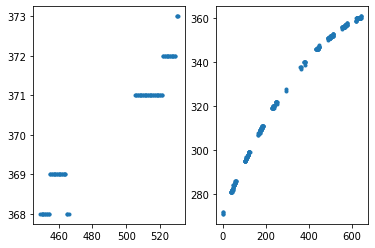

In [134]:
pts_l = np.concatenate(cont_l).squeeze()
pts_r = np.concatenate(cont_r).squeeze()

print(pts_l.shape, pts_r.shape)
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.plot(pts_l[:,0], pts_l[:,1], '.')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(pts_r[:,0], pts_r[:,1], '.')

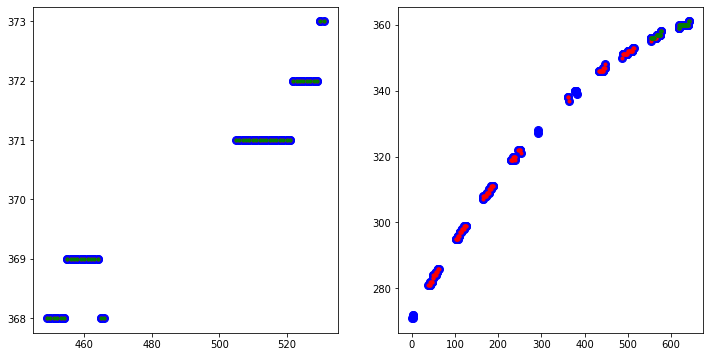

In [135]:
# try using `centerline_from_contours` function
len_thresh = -1
out_thresh = 1.5
n_neigh = 10
bspl_k = -1

ct_pts_l, bspline_l = centerline_from_contours(cont_l, len_thresh = len_thresh,
                                               outlier_thresh=out_thresh, num_neigbors=n_neigh,
                                               bspline_k = bspl_k)

# try using `centerline_from_contours` function
ct_pts_r, bspline_r = centerline_from_contours(cont_r, len_thresh = len_thresh,
                                               outlier_thresh=out_thresh, num_neigbors=n_neigh,
                                               bspline_k = bspl_k)

left_match, right_match = stereomatch_needle([ct_pts_l], [ct_pts_r])

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(pts_l[:,0], pts_l[:,1], 'b.', markersize=16)
ax1.plot(ct_pts_l[:,0], ct_pts_l[:,1], 'r.')
ax1.plot(left_match[:,0], left_match[:,1], 'g.')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(pts_r[:,0], pts_r[:,1], 'b.', markersize=16)
ax2.plot(ct_pts_r[:,0], ct_pts_r[:,1], 'r.')
ax2.plot(right_match[:,0], right_match[:,1], 'g.')

# stereo match the points
# left_match, right_match = stereomatch_needle(ct_pts_l, ct_pts_r, bspline_l=bspline_l, bspline_r=bspline_r)

# print(left_match.shape[0], right_match.shape[0])

option = 2

if (bspline_l is not None) and (bspline_r is not None):
    
    if option == 1:
        s = np.array([0, 1])
        x_l = bspline_l.unscale(s)
        x_r = bspline_r.unscale(s)
        al_l = bspline_l.arclength(x_l[0], x_l[1])
        al_r = bspline_r.arclength(x_r[0], x_r[1])
        s2 = 0.98
        al_l2 = bspline_l.arclength(x_l[0], bspline_l.unscale(s2))
        print('arclength:', al_l, al_r)

        # set-up optimization problem
        bnds = Bounds( 0, 1 )
        xr_tip = x_r[1]
        arclen_r = lambda s: bspline_r.arclength( bspline_r.unscale( s ), xr_tip )
        cost_fn_sc = lambda s: np.abs( bspline_l._scale(al_l) -  bspline_r._scale(arclen_r( s )) )
        cost_fn_t = lambda s: np.abs( al_l -  arclen_r( s ) )
        cost_fn = cost_fn_sc

        res = minimize( cost_fn,[.9], method = 'SLSQP', bounds = bnds )

        print('scaled result:', res.x[0], cost_fn(res.x))

        sr_opt_sc = res.x[0]

        sr = np.linspace(sr_opt_sc, 1, 200)
        left_match = ct_pts_l.copy()
        xr = bspline_r.unscale(sr)
        right_match = np.vstack((xr, bspline_r(xr))).T

        print(xr.shape, right_match.shape)

        ax1.plot(left_match[:,0], left_match[:,1], 'g.')
        ax2.plot(right_match[:,0], right_match[:,1], 'g.')

        conts_l = [np.vstack((left_match.astype(int), np.flip(left_match, axis=0).astype(int)))]
        conts_r = [np.vstack((right_match.astype(int), np.flip(right_match, axis=0).astype(int)))]

        left_cont = left_img.copy()
        right_cont = right_img.copy()

        cv.drawContours(left_cont, conts_l, -1, [0, 255, 0], 2)
        cv.drawContours(right_cont, conts_r, -1, [0, 255, 0], 2)


        plt.figure(figsize=(12,8))
        plt.imshow(imconcat(left_cont, right_cont, [0, 0, 255]))
        plt.title('scaled')

        # try the other cost function
        cost_fn = cost_fn_t

        res = minimize( cost_fn,[.9], method = 'SLSQP', bounds = bnds )

        print('unscaled result:', res.x[0], cost_fn(res.x))

        sr_opt_t = res.x[0]

        sr = np.linspace(sr_opt_t, 1, 200)
        left_match = ct_pts_l.copy()
        xr = bspline_r.unscale(sr)
        right_match = np.vstack((xr, bspline_r(xr))).T

        print(xr.shape, right_match.shape)

        ax1.plot(left_match[:,0], left_match[:,1], 'y.')
        ax2.plot(right_match[:,0], right_match[:,1], 'y.')
        ax2.legend(['img', 'func', 'scaled match', 'unscaled match'])


        conts_l = [np.vstack((left_match.astype(int), np.flip(left_match, axis=0).astype(int)))]
        conts_r = [np.vstack((right_match.astype(int), np.flip(right_match, axis=0).astype(int)))]

        left_cont = left_img.copy()
        right_cont = right_img.copy()

        cv.drawContours(left_cont, conts_l, -1, [0, 255, 0], 2)
        cv.drawContours(right_cont, conts_r, -1, [0, 255, 0], 2)


        plt.figure(figsize=(12,8))
        plt.imshow(imconcat(left_img, right_img, [0, 0, 255]))
        plt.title('image')

        plt.figure(figsize=(12,8))
        plt.imshow(imconcat(left_cont, right_cont, [0, 0, 255]))
        plt.title('unscaled')

    if option == 2:
        left_match, right_match, sl_opt, sr_opt = match_bsplines(left_img, right_img,
                                                                 bspline_l, bspline_r, 51)
        
        print(sl_opt, '|', sr_opt)
        
        ax1.plot(left_match[:,0], left_match[:,1], 'g.')
        ax2.plot(right_match[:,0], right_match[:,1], 'g.')


# x_rb, err = find_param_along_bspline(bspline_r, x_r[1], al_l, lb=x_r[0], ub=x_r[1])

# mask = ct_pts_r[:,0] > x_rb


In [120]:
al_l = bspline_l.arclength(bspline_l.unscale(0), bspline_l.unscale(1))
al_r = bspline_r.arclength(bspline_r.unscale(0), bspline_r.unscale(1))
print((bspline_l.qmax - bspline_l.qmin)/(bspline_r.qmax - bspline_r.qmin))
print(al_l/al_r)

0.8390313390313391
0.5754545842602165


difference [103.  -21.5]
12 (2, 1, 2) (2, 2)
15 (1, 1, 2) (1, 2)


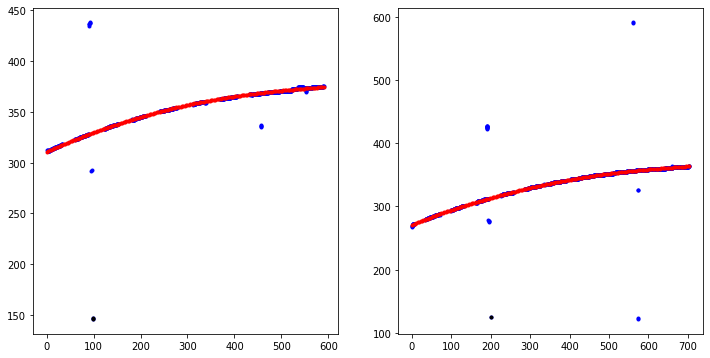

In [121]:
cont_l_min = np.reshape(cont_l[-1], (-1, 2))
cont_r_min = np.reshape(cont_r[-1], (-1, 2))

mean_l = np.mean(cont_l_min, axis=0)
mean_r = np.mean(cont_r_min, axis=0)

print('difference', mean_r - mean_l)

print(len(cont_l), cont_l[-1].shape, cont_l_min.shape)
print(len(cont_r), cont_r[-1].shape, cont_r_min.shape)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(pts_l[:,0], pts_l[:,1], 'b.')
ax1.plot(ct_pts_l[:,0], ct_pts_l[:,1], 'r.')
ax1.plot(cont_l_min[:,0], cont_l_min[:,1], 'k.')


ax2 = fig.add_subplot(1,2,2)
ax2.plot(pts_r[:,0], pts_r[:,1], 'b.')
ax2.plot(ct_pts_r[:,0], ct_pts_r[:,1], 'r.')
ax2.plot(cont_r_min[:,0], cont_r_min[:,1], 'k.')


In [51]:
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor

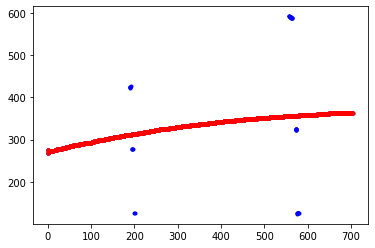

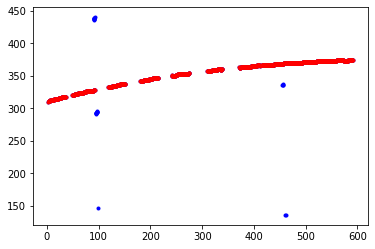

In [80]:
clf = LocalOutlierFactor(n_neighbors=20, contamination='auto')
clf.fit_predict(pts_r)
scores = clf.negative_outlier_factor_

mask = np.abs(-1-scores) < 0.5

pts_r_in = pts_r[mask]

plt.figure()
plt.plot(pts_r[:,0], pts_r[:,1],'b.')
plt.plot(pts_r_in[:,0], pts_r_in[:,1], 'r.')

clf.fit_predict(pts_l)
scores_l = clf.negative_outlier_factor_
mask_l = np.abs(-1-scores_l) < 0.5
pts_l_in = pts_l[mask_l]

plt.figure()
plt.plot(pts_l[:,0], pts_l[:,1], 'b.')
plt.plot(pts_l_in[:,0], pts_l_in[:,1], 'r.')

In [83]:
np.flip(np.arange(6).reshape(3,2), axis=0)e

array([[4, 5],
       [2, 3],
       [0, 1]])

# Stereo Reconstruction

## First Method : Bspline Cost function
Method:
1. Initialize 3-D stereo reconstruction
2. Project using stereo parameters
3. Measure error in 2-D bspline images.

In [36]:
curv_dir = curvature_dir[3]
print(curv_dir)
rois_lr = np.load(curv_dir + 'rois_lr.npy')
img_num = 2
left_img = cv.imread(curv_dir + f"left-{img_num:04d}.png", cv.IMREAD_ANYCOLOR)
right_img = cv.imread(curv_dir + f"right-{img_num:04d}.png", cv.IMREAD_ANYCOLOR)
rois_l = rois_lr[:,:,0:2].tolist()
rois_r = rois_lr[:,:,2:4].tolist()
roi_l = tuple(rois_l[img_num])
roi_r = tuple(rois_r[img_num])


../data/stereo_validation_jig/k_3.2/


In [103]:
def cost_proj3d(coeffs, pts_ref_l, pts_ref_r, stereo_params: dict, order: int ):
    ''' 2-D points should be of shape 2 X N'''
    # get the bspline 3-D points
    c = coeffs.reshape(3, order)
    bspline = BSpline3D(order, c)
    s = np.linspace(0, 1, pts_ref_l.shape[1])
    bspl_pts = bspline(s)
    
    # project each of the points
    bspl_proj_l = cv.projectPoints(bspl_pts, np.eye(3), np.zeros(3), stereo_params['cameraMatrix1'], stereo_params['distCoeffs1'])[0].squeeze().T
    bspl_proj_r = cv.projectPoints(bspl_pts, stereo_params['R'], stereo_params['t'], stereo_params['cameraMatrix2'], stereo_params['distCoeffs2'])[0].squeeze().T
    
    # calculate standard 3-D cost
    cost_per_pt = np.sum(np.abs(pts_ref_l - bspl_proj_l)**2, axis=1) + np.sum(np.abs(pts_ref_r - bspl_proj_r), axis=1)
    cost = np.sum(cost_per_pt)
    
    return cost
    

# cost_proj3d
    
def stereo_reconstruction(left_img, right_img, bor_l: list = [], bor_r: list = [],
                          roi_l: tuple = (), roi_r: tuple = (),
                          proc_show: bool = False):
    # Get the 2-D image skeletons
    left_skel, right_skel, conts_l, conts_r = imgproc_jig(left_img, right_img,
                                                                bor_l, bor_r, 
                                                                roi_l, roi_r,
                                                                proc_show)
    # fit a bspline to each contour (for interpolation)
    len_thresh = 5
    bspl_k = 3
    out_thresh = 1.25
    n_neigh = 20
    pts_l, bspline_l = centerline_from_contours( conts_l,
                                                 len_thresh = len_thresh,
                                                 bspline_k = bspl_k,
                                                 outlier_thresh = out_thresh,
                                                 num_neigbors = n_neigh )
    
    pts_r, bspline_r = centerline_from_contours( conts_r,
                                                 len_thresh = len_thresh,
                                                 bspline_k = bspl_k,
                                                 outlier_thresh = out_thresh,
                                                 num_neigbors = n_neigh )
    
    # get the pixel points in the images
    pts_px_l = np.unique(pts_l.astype(int), axis=0)
    pts_px_r = np.unique(pts_r.astype(int), axis=0)
    
    
    # perform an optimization over the bspline points (3-D to 2-D projection)
    
    
    
    return bspline_l, bspline_r, pts_l, pts_r
    
    
    
# stereo_reconstruction
    

In [40]:
bspline_l, bspline_r, pts_l, pts_r = stereo_reconstruction(left_img, right_img, roi_l = roi_l, roi_r = roi_r, proc_show=False)
s = np.linspace(0,1,200)
pts_bspl_l = np.vstack((bspline_l.unscale(s), bspline_l.eval_unscale(s))).T
pts_bspl_r = np.vstack((bspline_r.unscale(s), bspline_r.eval_unscale(s))).T

pts_bspl_dis_l = np.unique()

(271.9805573587931, 402.26036074868597)

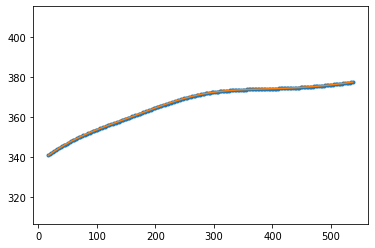

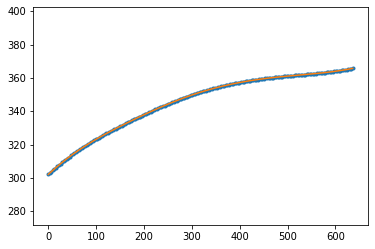

In [43]:
plt.figure()
plt.plot(pts_l[:,0], pts_l[:,1], '.')
plt.plot(pts_bspl_l[:,0], pts_bspl_l[:,1])
plt.ylim(0.9*min(pts_l[:,1]), 1.1*max(pts_l[:,1]))

plt.figure()
plt.plot(pts_r[:,0], pts_r[:,1], '.')
plt.plot(pts_bspl_r[:,0], pts_bspl_r[:,1])
plt.ylim(0.9*min(pts_r[:,1]), 1.1*max(pts_r[:,1]))

### Test out B-Spline fitting

In [12]:
coeffs = np.arange(6).reshape(-1,1)
coeffs = np.eye(5)[0,:].reshape(-1,1)
x = [0,1]
s = [0,1]
bp = BPoly(coeffs, x)

print(bp.c.flatten())
bp(s)

ValueError: axis=1 must be between 0 and 1

In [6]:
def bern_basis(order):
    C = np.eye(order)
    
    basis = []
    for i in range(order):
        coeff = C[i,:].reshape(-1,1)
        basis.append(BPoly(coeff, [0,1]))
    
    # for
    
    return basis

# bern_basis

def bern_call(bern_list, s):
    retval = []
    for bp in bern_list:
        retval.append(bp(s))
        
    return retval

# def

s = [0, 0.25, 0.5, 0.75, 1]
basis = bern_basis(3)
A = np.array(bern_call(basis, s))

pts = np.arange(3*len(s)).reshape(len(s), 3)
print(A.shape, pts.shape)

x, *_ = np.linalg.lstsq(A.T, pts, rcond=None)
print(x.shape,'\n', x.round(3))

print(np.round(A.T @ x, 3))
print(pts)
bp3 = BSpline3D(3, x.T)
bp3(s).round(3) - pts.T

(3, 5) (5, 3)
(3, 3) 
 [[-0.  1.  2.]
 [ 6.  7.  8.]
 [12. 13. 14.]]
[[-0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]
 [ 9. 10. 11.]
 [12. 13. 14.]]
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]


array([[-0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

Test the cost function and minimziation

Test cost function
Cost =  0.0

Test optimization
Optimal Cost 2.407349846924532e+29
[ 3.06004474e-01 -9.08012484e-01  1.34297024e+00 -2.20471015e+00
 -3.36370230e-01  3.95716890e-01 -9.93157806e+01 -2.14125765e+02
  4.79981433e+02] 
 [[ 0.3285971  -0.79619855  1.40312383]
 [-1.54779275  1.1667303   1.14772265]
 [ 0.13010933  0.43142236 -0.86831976]]
(3, 80) (3, 80) (80,)


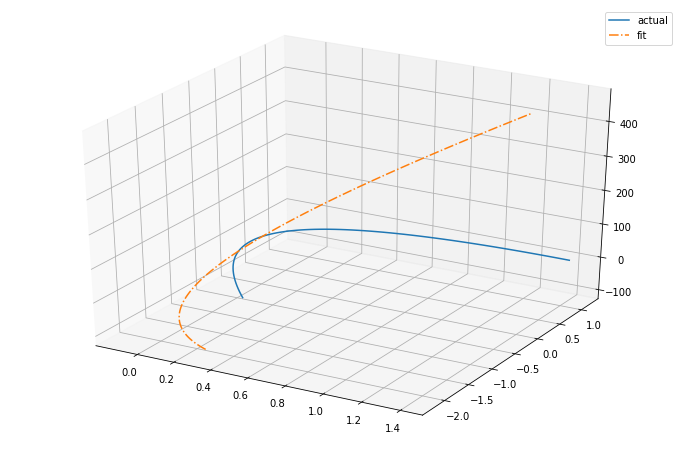

In [180]:
def cost_proj3d(coeffs, pts_ref_l, pts_ref_r, stereo_params: dict, order: int ):
    ''' 2-D points should be of shape 2 X N'''
    # get the bspline 3-D points
    c = coeffs.reshape(3, order)
    bspline = BSpline3D(order, c)
    s = np.linspace(0, 1, pts_ref_l.shape[1])
    bspl_pts = bspline(s)
    
    # project each of the points
    bspl_proj_l = cv.projectPoints(bspl_pts, np.eye(3), np.zeros(3), stereo_params['cameraMatrix1'], stereo_params['distCoeffs1'])[0].squeeze().T
    bspl_proj_r = cv.projectPoints(bspl_pts, stereo_params['R'], stereo_params['t'], stereo_params['cameraMatrix2'], stereo_params['distCoeffs2'])[0].squeeze().T
    
    # calculate standard 3-D cost
    cost_per_pt = np.sum((pts_ref_l - bspl_proj_l)**2, axis=1) + np.sum((pts_ref_r - bspl_proj_r)**2, axis=1)
    cost = np.sum(cost_per_pt)
    
    return cost
    

# cost_proj3d

# start testing
np.random.seed(110)
order = 3
coeffs = np.random.randn(3,order)
bp3 = BSpline3D(order, coeffs) # true function
s = np.linspace(0, 1, 80)
bspl_pts = bp3(s)

# cost function test
print('Test cost function')

left_proj = cv.projectPoints(bspl_pts, np.eye(3), np.zeros(3), stereo_params['cameraMatrix1'], stereo_params['distCoeffs1'])[0].squeeze().T
right_proj = cv.projectPoints(bspl_pts, stereo_params['R'], stereo_params['t'], stereo_params['cameraMatrix2'], stereo_params['distCoeffs2'])[0].squeeze().T

print('Cost = ', cost_proj3d(bp3.coeffs.flatten(), left_proj, right_proj, stereo_params, order))


# test optimization
print('\nTest optimization')

coeffs_init = coeffs + np.random.randn(*coeffs.shape)/25

res = minimize(cost_proj3d, coeffs_init.flatten(), args=(left_proj, right_proj, stereo_params, order))
print('Optimal Cost', res.fun)
print(res.x, '\n', coeffs)
bp3_opt = BSpline3D(order, res.x.reshape(3, order))
bp3_pts = bp3(s)
bp3_opt_pts = bp3_opt(s)

print(bp3_pts.shape, bp3_opt_pts.shape, s.shape)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.plot3D(bp3_pts[0,:], bp3_pts[1,:],bp3_pts[2,:])
ax.plot3D(bp3_opt_pts[0,:], bp3_opt_pts[1,:],bp3_opt_pts[2,:],'-.')
plt.legend(['actual', 'fit'])

In [143]:
a = np.random.randn(5,3)
print(np.sum(a, axis=1).shape, np.sum(a, axis=0).shape)

(5,) (3,)


## Second Method: Stereo Rectification
Using stereoRectification and then disparity mapping

In [177]:
def stereo_rectify2(img_left, img_right, stereo_params, interp_method = cv.INTER_LINEAR, alpha:float = -1, 
                   force_recalc: bool=False):
    # gray-scale the image
    left_gray = cv.cvtColor(img_left, cv.COLOR_BGR2GRAY)
    right_gray = cv.cvtColor(img_right, cv.COLOR_BGR2GRAY)
    
    # perform stereo rectification
    K_l = stereo_params['cameraMatrix1'].astype(float)
    K_r = stereo_params['cameraMatrix2'].astype(float)
    dists_l = stereo_params['distCoeffs1'].astype(float)
    dists_r = stereo_params['distCoeffs2'].astype(float)
    R = stereo_params['R'].astype(float)
    t = stereo_params['t'].astype(float)
    
    if force_recalc or any(k not in stereo_params.keys() for k in ['R1', 'R2', 'P1', 'P2']):
        R_l, R_r, P_l, P_r, Q, roi_l, roi_r = cv.stereoRectify(K_l, dists_l, K_r, dists_r, left_gray.shape[::-1], 
                                                 R, t, alpha=alpha)
        stereo_params['R1'] = R_l
        stereo_params['R2'] = R_r
        stereo_params['P1'] = P_l
        stereo_params['P2'] = P_r
        stereo_params['Q'] = Q
        rois_lr = (roi_l, roi_r)
        
    # if
    
    else:
        R_l = stereo_params['R1']
        R_r = stereo_params['R2']
        P_l = stereo_params['P1']
        P_r = stereo_params['P2']
        rois_lr = tuple(2*[[[0, 0], [-1, 1]]])
        
    # else
    
    print(P_l, '\n', P_r, end='\n\n')
    print(P_l - P_r)
    
    # compute stereo rectification map
    map1_l, map2_l = cv.initUndistortRectifyMap(K_l, dists_l, R_l, P_l, left_gray.shape[::-1], cv.CV_32FC1)
    map1_r, map2_r = cv.initUndistortRectifyMap(K_r, dists_r, R_r, P_r, right_gray.shape[::-1], cv.CV_32FC1)
    
    # apply stereo rectification map
    img_left = roi(img_left, roi_l, full=True)
    img_right = roi(img_right, roi_r, full=True)
    left_rect = cv.remap(img_left, map1_l, map2_l, interp_method)
    right_rect = cv.remap(img_right, map1_r, map2_r, interp_method)
    
    return left_rect, right_rect, rois_lr, (map1_l, map2_l), (map1_r, map2_r)
    
# stereo_rectify

[[1.87576720e+03 0.00000000e+00 5.05920929e+02 0.00000000e+00]
 [0.00000000e+00 1.87576720e+03 4.00898312e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]] 
 [[1.87576720e+03 0.00000000e+00 5.05920929e+02 8.39361850e+04]
 [0.00000000e+00 1.87576720e+03 4.00898312e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]

[[     0.              0.              0.         -83936.18504259]
 [     0.              0.              0.              0.        ]
 [     0.              0.              0.              0.        ]]
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
validROI: <class 'tuple'> 2 (0, 0, 937, 768) (87, 0, 937, 768)


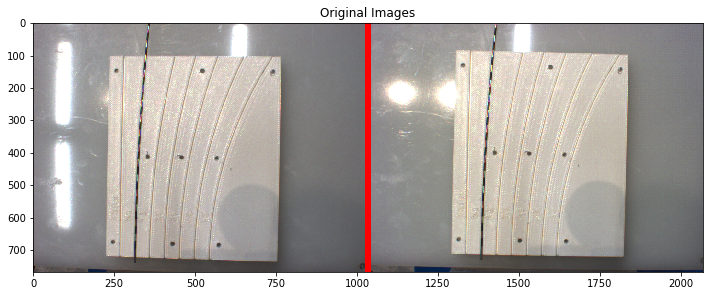

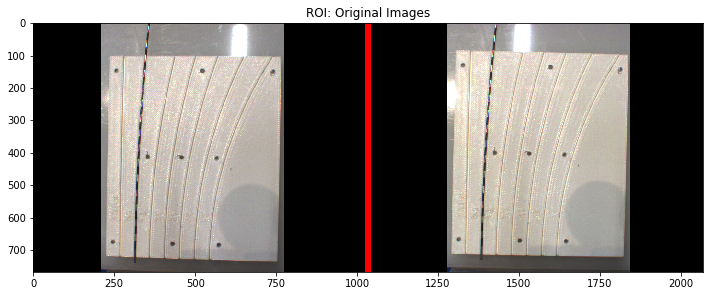

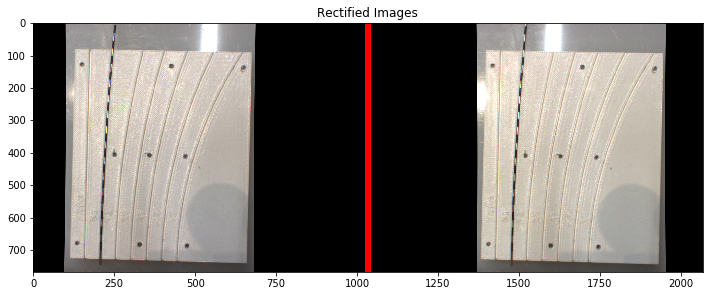

In [4]:
# set-up
roi_all = []
roi_l = [[0, 210], [-1, 775]]
roi_r = [[0, roi_l[0][1] + 25], [-1, roi_l[1][1] + 25]]

# roi images
left_roi = roi(left_img, roi_l, full=True)
right_roi = roi(right_img, roi_r, full=True)

# stereo rectification
left_rect, right_rect, valid_roi_lr, *maps = stereo_rectify(left_roi, right_roi, stereo_params, cv.INTER_LINEAR,
                                                           force_recalc=True, alpha=0.5)

print(left_img.shape, right_img.shape)
print(left_rect.shape, right_rect.shape)

# plotting
plt.figure(figsize=(12,8))
plt.imshow(imconcat(left_img, right_img, [255, 0, 0]),cmap='gray')
plt.title('Original Images')

plt.figure(figsize=(12,8))
plt.imshow(imconcat(left_roi, right_roi, [255, 0, 0]),cmap='gray')
plt.title('ROI: Original Images')

plt.figure(figsize=(12,8))
plt.imshow(imconcat(left_rect, right_rect, [255,0, 0]))
plt.title('Rectified Images')



print('validROI:', type(valid_roi_lr), len(valid_roi_lr), valid_roi_lr[0], valid_roi_lr[1] )


### Stereo Reconstruction Method

Procedure:
1. Rectify input images using `stereo_rectify` function.
2. From the rectified images, determine the location of the needle using image processing
3. Using the locations of the needle, perform a "disparity" triangulation algorithm. 
    - This will most likely use `cv.triangulatePoints`

In [ ]:
def needle_reconstruction2(img_left, img_right, stereo_params, 
                           bor_l:list = [], bor_r:list = [],
                           roi_l = (), roi_r = (), 
                           alpha: float = 0.5, recalc_stereo:bool = False):
    ''' This is function for performing a 3-D needle reconstruction from a raw stereo pair'''
    # prepare images
    ## roi the images
    left_roi = roi(img_left, roi_l, full=True)
    right_roi = roi(img_right, roi_r, full=True)
    
    ## black-out regions
    left_roibo = blackout_regions(left_roi, bor_l)
    right_roibo = blackout_regions(right_roi, bor_r)
    
    # stereo rectify the images
    left_rect, right_rect, valid_roi_lr, *maps = stereo_rectify(left_roibo, right_roibo, stereo_params, 
                                                                interp_method = cv.INTER_LINEAR, alpha=alpha, 
                                                                force_recalc = recalc_stereo)
    
    # perform image processing on rectified images
    
    
    
# needle_reconstruction2